# 02c Merge datasets across regions and domains 

---

In [1]:
#|default_exp core.02c_merge_data

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

--- 

In [6]:
# Load the datasets with Local Authority District demographic info 
df_lad_age_21 = pd.read_csv(const.output_path+'/LAD_age_2021.csv')
df_lad_ethn_21 = pd.read_csv(const.output_path+'/LAD_ethnicity_percent_2021.csv')
df_lad_educ_21 = pd.read_csv(const.output_path+'/LAD_education_2021.csv')

# And the ADI health dataset
df_ADI_health_21 = pd.read_csv(const.data_path+'/ADI_data/ADI_health_2021.csv')

# and the GP practice catchment overlap with LADs
df_LAD_GP_pop = pd.read_csv(const.output_path+'/GP_LAD_intersections.csv')

In [7]:
print(f'Number of LADs in the ADI dataset: {len(df_ADI_health_21)}. Number of LADs in the demographic dataset: {len(df_lad_age_21)}.')

Number of LADs in the ADI dataset: 309. Number of LADs in the demographic dataset: 331.


In [8]:
# Fix the mismatch in LADs resulting from the inclusion of Welsh LADs - poor old Wales :(
wales_LAD = list(df_lad_age_21[~df_lad_age_21['LAD_name'].isin(df_ADI_health_21['area_name'])]['LAD_name'])

# Drop all the LADs in Wales from datasets 
df_lad_age_21.drop(df_lad_age_21[df_lad_age_21['LAD_name'].isin(wales_LAD)].index, inplace=True)
df_lad_educ_21.drop(df_lad_educ_21[df_lad_educ_21['Area name'].isin(wales_LAD)].index, inplace=True)
df_lad_ethn_21.drop(df_lad_ethn_21[df_lad_ethn_21['Area name'].isin(wales_LAD)].index, inplace=True)

Now a little bit of processing to merge categories and get an informative percent. For covariates I'm looking at:
* percent of the population over 65
* percent of the population with A-level or higher qualifications 
* percent of the population who have white ethnicity 

In [9]:
df_lad_educ_21['ALevel_plus'] = df_lad_educ_21['level 3: a-level']+df_lad_educ_21['level 4: bsc']

Also want to look at the health conditions which might be confounders, specifically:
- Hypertension (HYP)
- Diabetes (DM)
- Stroke + Coronary heart disease + Transient ischaemic attack (STIA)

Could also consider:
- Depression (DEP)
- Parkinsonism - not in the QOF dataset - I suspect this is clustered under dementia 
- Chronic Obstructive Pulmonary disease (COPD)
- asthma (AST)
- Cardiovascular disease (CVD-PP)
- Age-related musculoskeletal disorders - not in the QOF dataset 

The codes for each health domain come from: health_indicator_keys.xlsx available via ADI 

In [10]:
# merge the datasets into one 
df_dem_educ = pd.merge(df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted', 'HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']], df_lad_educ_21[['Area name', 'ALevel_plus']], left_on='area_name', right_on='Area name')
df_dem_educ_age = pd.merge(df_dem_educ, df_lad_age_21, left_on='area_name', right_on='LAD_name')
df_dem_covar =  pd.merge(df_dem_educ_age, df_lad_ethn_21[["Area name","White: English, Welsh, Scottish, Northern Irish or British\n(percent)"]], left_on='area_name', right_on='Area name')

# rename long col name
df_dem_covar.rename(axis=1, mapper={'White: English, Welsh, Scottish, Northern Irish or British\n(percent)':'white_pc'}, inplace=True)

# drop some duplicated columns 
df_dem_covar.drop(axis=1, labels=['Area name_x', 'Area name_y', 'LAD_name'], inplace=True)

In [11]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,white_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,93.2
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,63.0
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,84.2
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,87.8
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,93.8


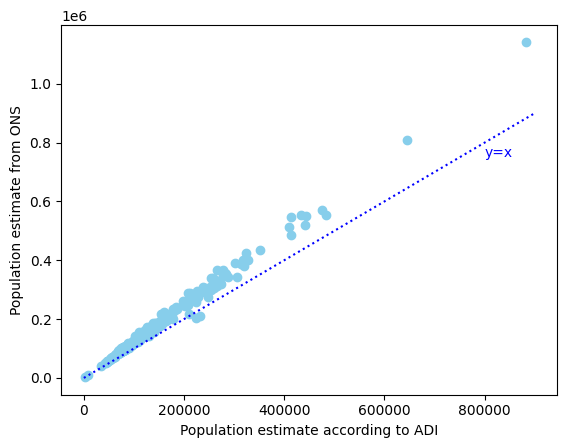

In [12]:
plt.scatter(df_dem_covar['pop'], df_dem_covar['all_age'], color = 'skyblue')
plt.plot(np.arange(900000), np.arange(900000), ':', color='b')
plt.text(800000, 750000, r'y=x', fontsize=10, color='b')
plt.xlabel('Population estimate according to ADI')
plt.ylabel('Population estimate from ONS')
plt.show()

In [13]:
# and columns with disease prevalence for the comorbidities of hypertension (HYP), diabetes (DM) and stroke (STIA)
df_dem_covar['HYP_afflicted_pc'] = df_dem_covar['HYP_afflicted']/df_dem_covar['pop']
df_dem_covar['DM_afflicted_pc'] = df_dem_covar['DM_afflicted']/df_dem_covar['pop']
df_dem_covar['STIA_afflicted_pc'] = df_dem_covar['STIA_afflicted']/df_dem_covar['pop']

In [14]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,93.2,0.190731,0.061649,0.029487
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,63.0,0.103726,0.036506,0.012880
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,84.2,0.135847,0.048480,0.019880
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,87.8,0.136400,0.055064,0.021488
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,93.8,0.159655,0.062981,0.022507


In [15]:
# save a .csv of `df_dem_covar`
df_dem_covar.to_csv(const.output_path+'/df_dem_plus.csv', index=False)

In [16]:
df_LAD_GP_pop

,gp_index,intersection_size,pop,LAD,gp_name
0,7228,154.810845,51241.009004,Hartlepool,A81070 - WYNYARD ROAD PRIMARY CARE CENTRE
1,1607,168.866010,55893.143290,Hartlepool,A81622 - GLADSTONE HOUSE SURGERY
2,7219,185.284987,61327.677980,Hartlepool,A81060 - THE KOH PRACTICE
3,7959,189.603022,62756.909149,Hartlepool,A81044 - MCKENZIE HOUSE SURGERY
4,2654,214.436151,70976.453448,Hartlepool,A81007 - BANKHOUSE SURGERY
...,...,...,...,...,...
15167,8556,12.274104,45040.765372,Westminster,E87026 - MEANWHILE GARDEN MEDICAL CENTRE
15168,6172,0.000029,0.106191,Westminster,E87701 - THE ABINGDON HEALTH CENTRE
15169,4057,0.084800,311.181309,Westminster,F83048 - BRUNSWICK MEDICAL CENTRE UHPC
15170,4067,0.008687,31.875834,Westminster,F83058 - HOLBORN MEDICAL CENTRE


In [17]:
df_GP_count = pd.read_csv(const.data_path+'/GP_practices_dec_23/gp_Count.csv')

In [46]:
df_GP_count

,Comm./Prov.,Code,Practice Name,Practice Address,Code.1,GP Count,Dispensing List Size,Prescribing List Size,Total List Size
0,BARTS HEALTH NHS TRUST,R1H00,BARTS HEALTH NHS TRUST CHS,"BEAUMONT HOUSE, ROOM 31, MILE END HOSPITAL, LO...",Y05462,1,NaN,NaN,NaN
1,BEXLEY HEALTH NEIGHBOURHOOD CARE,DFJ00,GUARD YOUR HEART HUB,"C/O BELLGROVE SURGERY, 174 BELLGROVE ROAD, WEL...",Y08001,1,NaN,NaN,NaN
2,BMI HEALTHCARE,NT400,BMI BEAUMONT HOSPITAL,"OLD HALL CLOUGH, CHORLEY NEW ROAD LOSTOCK, BOL...",Y06646,1,NaN,NaN,NaN
3,BMI HEALTHCARE,NT400,BMI BISHOPSWOOD HOSPITAL,"RICKMANSWORTH ROAD, NORTHWOOD, MIDDLESEX, HA6 2JW",Y06603,1,NaN,NaN,NaN
4,BMI HEALTHCARE,NT400,BMI CHAUCER HOSPITAL,"NACKINGTON ROAD, CANTERBURY, KENT, CT4 7AR",Y04413,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1866,WEST LONDON NHS TRUST,RKL00,EALING ADULT LEARNING DISABILITY,"1 ARMSTRONG WAY, SOUTHALL, MIDDLESEX, LONDON, ...",Y00535,1,NaN,NaN,NaN
1867,WEST LONDON NHS TRUST,RKL00,EALING PCT MUSCULOSKELETAL SERVICE,"CLAYPONDS HOSPITAL, STERLING PLACE, W5 4RN",Y01169,1,NaN,NaN,NaN
1868,WEST LONDON NHS TRUST,RKL00,EALING TRI-BOROUGH PERINATAL MH SERVICE,"ST BERNARD'S HOSPITAL, UXBRIDGE ROAD, SOUTHALL...",Y06365,1,NaN,NaN,NaN
1869,WEST LONDON NHS TRUST,RKL00,HAMM & FULHAM PERINATAL MH SERVICE,"PERINATAL MHS BUILDNG 135, HAMMERSMITH HOSPITA...",Y06366,1,NaN,NaN,NaN


In [49]:
practice_size_nonzero = df_GP_count[df_GP_count['Total List Size']>0]
practice_size_nonzero.head()

,Comm./Prov.,Code,Practice Name,Practice Address,Code.1,GP Count,Dispensing List Size,Prescribing List Size,Total List Size
163,NHS NORTH CENTRAL LONDON ICB - 93C,93C00,ABBEY MEDICAL CENTRE,"ABBEY MEDICAL CENTRE, 85 ABBEY ROAD, LONDON, N...",F83019,12,0.0,13443.0,13443.0
164,NHS NORTH CENTRAL LONDON ICB - 93C,93C00,ABERNETHY HOUSE SURGERY,"ABERNETHY HOUSE SURGERY, 70 SILVER STREET, ENF...",F85029,18,0.0,12301.0,12301.0
165,NHS NORTH CENTRAL LONDON ICB - 93C,93C00,ADDINGTON MEDICAL CENTRE,"ADDINGTON MEDICAL CENTRE, 46 STATION ROAD, NEW...",E83044,8,0.0,9790.0,9790.0
166,NHS NORTH CENTRAL LONDON ICB - 93C,93C00,ADELAIDE MEDICAL CENTRE,"ADELAIDE MEDICAL CENTRE, 111 ADELAIDE ROAD, LO...",F83020,15,0.0,11767.0,11767.0
167,NHS NORTH CENTRAL LONDON ICB - 93C,93C00,ADLER JS-THE SURGERY,"682 FINCHLEY ROAD, GOLDERS GREEN, LONDON, NW11...",E83600,4,0.0,6963.0,6963.0


In [52]:
practice_size_nonzero[practice_size_nonzero['GP Count']>40]

,Comm./Prov.,Code,Practice Name,Practice Address,Code.1,GP Count,Dispensing List Size,Prescribing List Size,Total List Size
300,NHS NORTH CENTRAL LONDON ICB - 93C,93C00,MEDICUS HEALTH PARTNERS,"FOREST PRIMARY CARE CTR, 308A HERTFORD ROAD, E...",F85002,74,0.0,93617.0,93617.0
1355,NHS SOUTH EAST LONDON ICB - 72Q,72Q00,HURLEY AND RIVERSIDE PRACTICES,"EBENEZER HOUSE, KENNINGTON LANE, LONDON, SE11 4HJ",G85053,60,0.0,22772.0,22772.0
1383,NHS SOUTH EAST LONDON ICB - 72Q,72Q00,NEXUS HEALTH GROUP,"PRINCESS STREET GP PRACT, 2 PRINCESS STREET, E...",G85034,48,0.0,76301.0,76301.0
1459,NHS SOUTH EAST LONDON ICB - 72Q,72Q00,THE LEWISHAM CARE PARTNERSHIP,"ST JOHNS MEDICAL CENTRE, 56-60 LOAMPIT HILL, L...",G85038,45,0.0,54714.0,54714.0


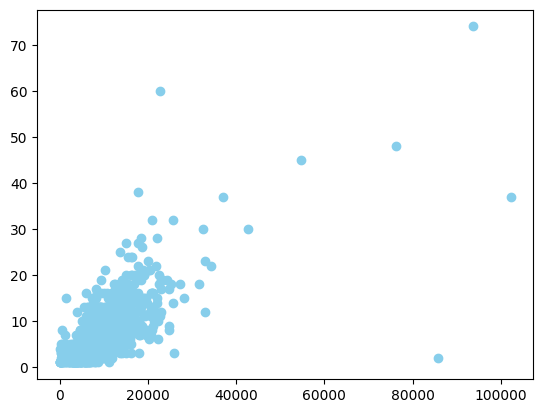

In [50]:
plt.scatter(practice_size_nonzero['Total List Size'], practice_size_nonzero['GP Count'], color = 'skyblue')

In [43]:
# Match GP count to GP practices we have geographical data for 

list_gps = df_LAD_GP_pop['gp_name'].values
list_gps_codes = [item[0:6] for item in list_gps]
gp_count_dict = {key: [] for key in ['code', 'name', 'gp_count']}

y=0

for i, code_num in enumerate(list_gps_codes):
    gp_count_code_str = df_GP_count[df_GP_count['Code.1']==code_num]
    if len(gp_count_code_str) == 1:
        gp_count = gp_count_code_str['GP Count'].values[0]
        gp_count_dict['code'].append(code_num)
        gp_count_dict['name'].append(list_gps[i])
        gp_count_dict['gp_count'].append(gp_count)
    if len(gp_count_code_str) > 1:
        # This is just to sanity check that there are no duplicated practices 
        y += 1

print(y)

In [44]:
pd.DataFrame.from_dict(gp_count_dict)

,code,name,gp_count
0,F82649,F82649 - BERWICK SURGERY,3
1,E85696,E85696 - CLIFFORD ROAD SURGERY,3
2,F82016,F82016 - KAKAD,3
3,F82010,F82010 - PETERSFIELD SURGERY,10
4,Y00312,"Y00312 - THE ROBINS SURGERY, HAROLD HILL HEALTH C",2
...,...,...,...
2558,E87026,E87026 - MEANWHILE GARDEN MEDICAL CENTRE,2
2559,E87701,E87701 - THE ABINGDON HEALTH CENTRE,8
2560,F83048,F83048 - BRUNSWICK MEDICAL CENTRE UHPC,19
2561,F83058,F83058 - HOLBORN MEDICAL CENTRE,14
